In [16]:
import numpy as np
import csv
import igl
import math
import ripleyK as rk
import ripleyKmito as rkt
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from scipy.io import loadmat 
import os
import plotly.graph_objects as go

In [17]:
def readmitodata(fname):
    """
    Expect a filename of the form "mito_data???.mat" 
    where ??? is the mito number (left padded by 0 is necessary).
    
    argument:
    fname -- string, filename of the mito data
    
    returns:
    mito_dict -- dictionary, keys are the names of the variables in the matlab file
    The keys are:
    'mito' -- the mitochondrion binary shaoe (np.ndarray, has been padded with zeros)
    'vertices' -- the vertices of the meshed mitochondrion (np.ndarray)  
    'faces' -- the faces of the meshed mitochondrion (np.ndarray)
    'cristae_junctions' -- the vertices of the cristae junctions (np.ndarray) or empty list if none
    'min_coords' -- the minimum coordinates of the mitochondrion (np.ndarray) in the original volume    
    'mito_number' -- the number of the mitochondrion (int) from the cc3d.component_labeling function,
                        this is the same as the number in the filename
    
    """
    mito_dict = loadmat(fname)
    # remove matlab meta data
    del mito_dict['__header__']
    del mito_dict['__version__']
    del mito_dict['__globals__']
    mito_dict['mito_number'] = int(mito_dict['mito_number'])
    # inverted results in matlab....
    mito_dict['vertices'], mito_dict['faces'] = mito_dict['faces'], mito_dict['vertices']
    # count starts at 0
    mito_dict['faces'] -= 1
    return mito_dict

In [18]:
# Calculating the distance between all pairs of points on the mesh
def pair_distance_mesh(vertices, faces, samples):
    npts = np.shape(samples)[0]
    dist = []
    sqrD, face_idx, cvecs = igl.point_mesh_squared_distance(samples, vertices, faces)
    # print(face_idx)
    # print("cvecs: ", cvecs)
    # print(faces[face_idx])
    # print(vecs[faces[face_idx]])
    for i in range(npts-1):
        # print(faces[face_idx])
        vs = np.array([faces[face_idx][i][1]])
        # print("vs:", vs)
        vt = np.array(faces[face_idx][i+1:,1:2])
        # print("vt:", vt)
        d = igl.exact_geodesic(vertices, faces, vs, vt)
        # print("d: ", d)
        dist.append(d)
    return dist

# Calculating the surface area of the mesh
def mesh_area(vecs, faces):
    double_areas = igl.doublearea(vecs, faces)
    surface_area = np.sum(double_areas) / 2.0
    return surface_area

# Ripley's K function for mesh
def ripleyK_mesh(vecs, faces, data):
    area = mesh_area(vecs, faces)
    dists = pair_distance_mesh(vecs, faces, data)
    dists = np.hstack(dists)
    rmax = np.max(dists)
    radii = np.linspace(0, rmax, 50)
    K = np.zeros(len(radii))
    intensity = len(dists) / area
    for i in range(len(radii)):
        K[i] = np.sum(dists < radii[i])
    K = K / intensity
    return radii, K

In [19]:
current_dir = os.getcwd()
folder_path = os.path.join(current_dir, "mito_data")
path = os.path.join(folder_path, "mito_data289.mat")
mito = readmitodata(path)  

In [20]:
print(mito.keys())
vertices = np.array(mito['vertices'], dtype=np.float64)
faces = np.array(mito['faces'], dtype=np.int32)
cj = np.array(mito['cristae_junction'], dtype=np.float64)

points = cj.T
points = points[:, [1, 0, 2]].astype(np.float64)
print(points.shape)
print(vertices.shape)
print(faces.shape)

print(vertices.min(), vertices.max())
print(faces.min(), faces.max())

area = mesh_area(vertices, faces)
print("area: ", area)

dict_keys(['cristae_junction', 'faces', 'min_coords', 'mito', 'mito_number', 'vertices'])
(46, 3)
(72970, 3)
(145936, 3)
1.505 253.495
0 72969
area:  53791.68827918994


In [25]:
uniform_points = rk.sample_faces(vertices, faces, 50)

x, y, z = vertices.T
i, j, k = faces.T

mesh = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, color='lightpink', opacity=0.50)
fig = go.Figure(data=[mesh])
fig.add_trace(go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=8, color='blue')))
# fig.add_trace(go.Scatter3d(x=points[:,0], y=points[:,2], z=points[:,1], mode='markers', marker=dict(size=8, color='magenta')))
# fig.add_trace(go.Scatter3d(x=points[:,1], y=points[:,0], z=points[:,2], mode='markers', marker=dict(size=8, color='red')))
# plot the uniform points
# fig.add_trace(go.Scatter3d(x=uniform_points[:,0], y=uniform_points[:,1], z=uniform_points[:,2], mode='markers', marker=dict(size=8, color='green')))
fig.show()

In [26]:
# dists = pair_distance_mesh(vertices, faces, points)
# dists = np.hstack(dists)
# dists_old = rkt.pair_distance_mesh(vertices, faces, points)
# print("dists_old: ", dists_old)
# print("dists: ", dists)

In [27]:
# poly = mpl_toolkits.mplot3d.art3d.Poly3DCollection(vertices[faces])
# poly.set_facecolor('red') 
# poly.set_edgecolor('black')
# poly.set_linewidth(0.01)
# poly.set_alpha(0.2)

# fig = plt.figure()
# # and now -- visualization!
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(points[:,0], points[:,1], points[:,2], c='blue', s=10)
# ax.scatter(points[:,1], points[:,0], points[:,2], c='red', s=10)

# ax.add_collection3d(poly) 
# plt.show()

In [28]:
#  Computes signed distance to a mesh

#  Inputs:
#    P  #P by 3 list of query point positions
#    V  #V by 3 list of vertex positions
#    F  #F by ss list of triangle indices, ss should be 3 unless sign_type ==
#      SIGNED_DISTANCE_TYPE_UNSIGNED
#    sign_type  method for computing distance _sign_ S
#    lower_bound  lower bound of distances needed {std::numeric_limits::min}
#    upper_bound  lower bound of distances needed {std::numeric_limits::max}
#  Outputs:
#    S  #P list of smallest signed distances
#    I  #P list of facet indices corresponding to smallest distances
#    C  #P by 3 list of closest points
#    N  #P by 3 list of closest normals (only set if
#      sign_type=SIGNED_DISTANCE_TYPE_PSEUDONORMAL)

# if points.size:
#     signed_dist = igl.signed_distance(points, vertices, faces)
#     print(signed_dist)

In [29]:
# sqrD, face_idx, cvecs = igl.point_mesh_squared_distance(points, vertices, faces)
# print(faces[face_idx])
# vs = np.array([faces[face_idx][0][1]])
# print("vs:", vs)
# vt = np.array(faces[face_idx][1:,1:2])
# print("vt:", vt)
# d = igl.exact_geodesic(vertices, faces, vs, vt)
# print("d: ", d)

In [6]:
if cj.size:
    kt_mito = ripleyK_mesh(vertices, faces, points)
    kt_uniform = ripleyK_mesh(vertices, faces, uniform_points)
    print(kt_mito)
    #data = np.column_stack((radii, kt_mito))
    #np.savetxt("kt_mito.csv", data, delimiter=",", header='radii,kt_mito')
else:
    print("No cristae junctions found")

: 

: 

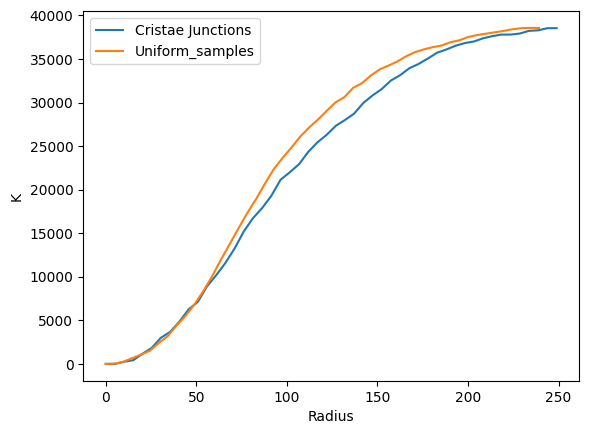

In [31]:
plt.plot(kt_mito[0], kt_mito[1], label='Cristae Junctions')
plt.plot(kt_uniform[0], kt_uniform[1], label='Uniform_samples')
plt.xlabel('Radius')
plt.ylabel('K')
plt.legend()
plt.savefig('kt_mito039.png')
plt.show()

In [22]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "mito_data")
result_dir = os.path.join(current_dir, "mito_result")

for file_name in os.listdir(data_dir):
    if file_name.endswith(".mat"):
        file_path = os.path.join(data_dir, file_name)
        mito = readmitodata(file_path)
        vertices = np.array(mito['vertices'], dtype=np.float64)
        faces = np.array(mito['faces'], dtype=np.int32)
        cj = np.array(mito['cristae_junction'], dtype=np.float64)
        points = cj.T
        points = points[:, [1, 0, 2]].astype(np.float64)
        if cj.size:
            print(file_name)
            dist = pair_distance_mesh(vertices, faces, points)
            dist = np.hstack(dist)
            result_path = os.path.join(result_dir, os.path.splitext(file_name)[0] + ".csv")
            np.savetxt(result_path, dist, delimiter=",", header='dists')
            print(file_name + " result saved")
        else:
            print("No cristae junctions found")

No cristae junctions found
mito_data002.mat
[16.55294536  6.08276253 17.4642492  18.78829423 51.68231423 19.10497317
 14.03566885 15.13274595 38.68009022 15.03329638 16.1245155  50.08002003
  1.41421356 36.64612435 35.79848427]
mito_data002.mat result saved
No cristae junctions found
No cristae junctions found
mito_data007.mat
[ 36.66166732   5.          55.91693056  25.83649089  52.21914972
  63.1491944   73.93631268  72.32362058  72.62981647  52.04087019
  88.71939439  80.1253105  102.42327973  93.42663592  40.20433532
  34.04755542  56.14882287  16.48323204  32.35901146  46.86873035
  59.85404347  39.55720159  75.16218295  60.01390097  88.40070501
  93.4878598   84.92398059  56.72636677  27.17694123  56.08540313
  67.7226796   78.80192578  77.20078331  77.0142366   52.17223283
  93.53861863  83.46546394 106.16087295  95.69504714  57.15858943
  39.50965669  57.80331998  72.74492401  90.48671646  59.36636826
  42.2331457   82.12295563  85.01103968  95.5271945   74.82395564
  68.763121

KeyboardInterrupt: 